## Import Libraries & Load Dataset  

Essential Python libraries are imported for data manipulation, visualization, and statistics.  

Next, we load the dataset [`lukebarousse/data_jobs`](https://huggingface.co/datasets/lukebarousse/data_jobs) which contains job postings related to data roles, and convert it into a Pandas DataFrame for analysis.

In [ ]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as mplp
import copy
import seaborn as sns
import random
import ast
from datasets import load_dataset
dataset = load_dataset("lukebarousse/data_jobs")
data=dataset['train'].to_pandas()


### Data Cleaning  

1. Convert `job_posted_date` from string to `datetime` for date-based analysis.  
2. Convert `job_skills` from string to list for easier manipulation and filtering.  


In [ ]:

data['job_posted_date'] =pd.to_datetime(data.job_posted_date)
data['job_skills']=data.job_skills.apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

Extraction of `month` from `job_posted_date` and ordering of months chronologically to make plotting and analysis more meaningful.


In [20]:
data['month']=data.job_posted_date.dt.month_name()
month_ordered = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

### Comparing Median Salaries by Job Title and Country  

Median yearly salaries are calculated by grouping data by `job_title_short` and `job_country`, focusing on United States and India. A horizontal bar chart is used for visualization.  


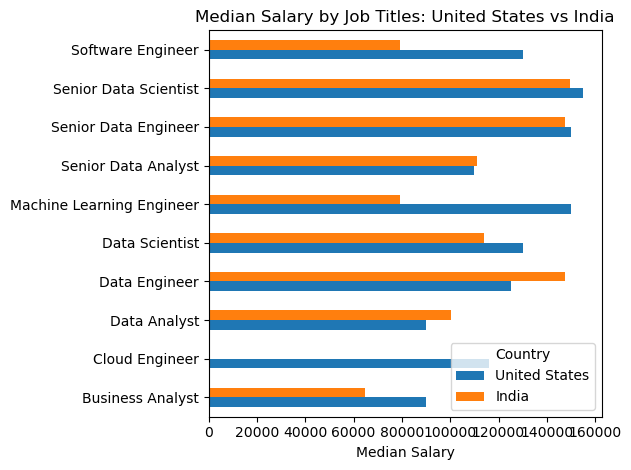

In [28]:
data.groupby(['job_title_short','job_country'])['salary_year_avg'].median().unstack().loc[:,['United States','India']].plot(kind='barh',xlabel='Median Salary',ylabel='',title='Median Salary by Job Titles: United States vs India')
mplp.tight_layout()
mplp.legend(title='Country')
mplp.show()


### Summary Statistics by Job Title  

Extended salary statistics are calculated for each `job_title_short`, including minimum, maximum, median, mean, standard deviation, and count of job postings.  


In [181]:
data.groupby('job_title_short')['salary_year_avg'].agg(['min', 'max', 'median', 'mean', 'std', 'count']).rename(columns={'min':'Minimum','max':'Maximum','median':'Median','mean':'Mean','std':'Standard Deviation','count':'Job Count'})

,Minimum,Maximum,Median,Mean,Standard Deviation,Job Count
job_title_short,,,,,,
Business Analyst,16500.0,387460.0,85000.0,91082.612833,32036.098388,610
Cloud Engineer,42000.0,280000.0,90000.0,111268.453846,50514.351080,65
Data Analyst,25000.0,650000.0,90000.0,93841.907854,34100.108034,5451
Data Engineer,15000.0,525000.0,125000.0,130125.604250,42525.929674,4500
Data Scientist,27000.0,960000.0,127500.0,135988.837171,52227.832196,5922
Machine Learning Engineer,30000.0,325000.0,106415.0,126774.315972,53914.993342,576
Senior Data Analyst,30000.0,425000.0,111175.0,113911.363665,34060.065096,1131
Senior Data Engineer,35000.0,425000.0,147500.0,145840.611624,37415.120392,1591
Senior Data Scientist,45000.0,890000.0,155500.0,154206.292996,50927.738257,1690


### Distribution of Yearly Salaries  

A histogram with 50 bins is used to show the distribution of `salary_year_avg`, with vertical lines for mean and median. The x-axis is limited to 0–450,000 to reduce the impact of outliers.  


Text(117000.0, 4500, 'Median: $115000')

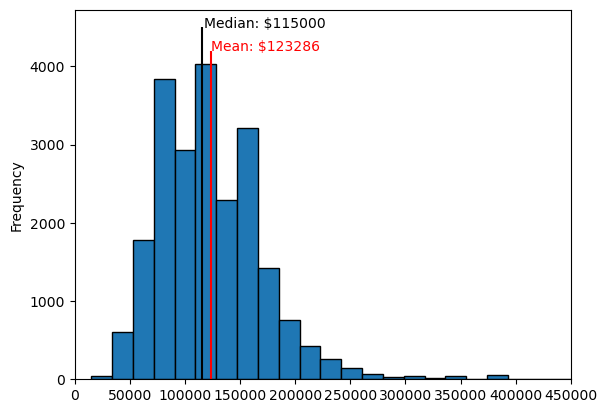

In [183]:
data.salary_year_avg.plot(kind='hist',bins=50,edgecolor='black',xlim=(0,450_000))
mplp.vlines(x=data.salary_year_avg.mean(),ymin=0,ymax=4200,color='red')
mplp.vlines(x=data.salary_year_avg.median(),ymin=0,ymax=4500,color='black')
mplp.text(x=data.salary_year_avg.mean(),color='red',y=4200,s=f'Mean: ${int(data.salary_year_avg.mean())}')
mplp.text(x=data.salary_year_avg.median()+2000,color='black',y=4500,s=f'Median: ${int(data.salary_year_avg.median())}')

### Top Skills for Selected Job Titles  

Analysis of the most frequent skills for `Data Analyst` and `Senior Data Analyst`. The top 10 skills for each role are calculated by frequency and percentage, then visualized with horizontal bar charts.  


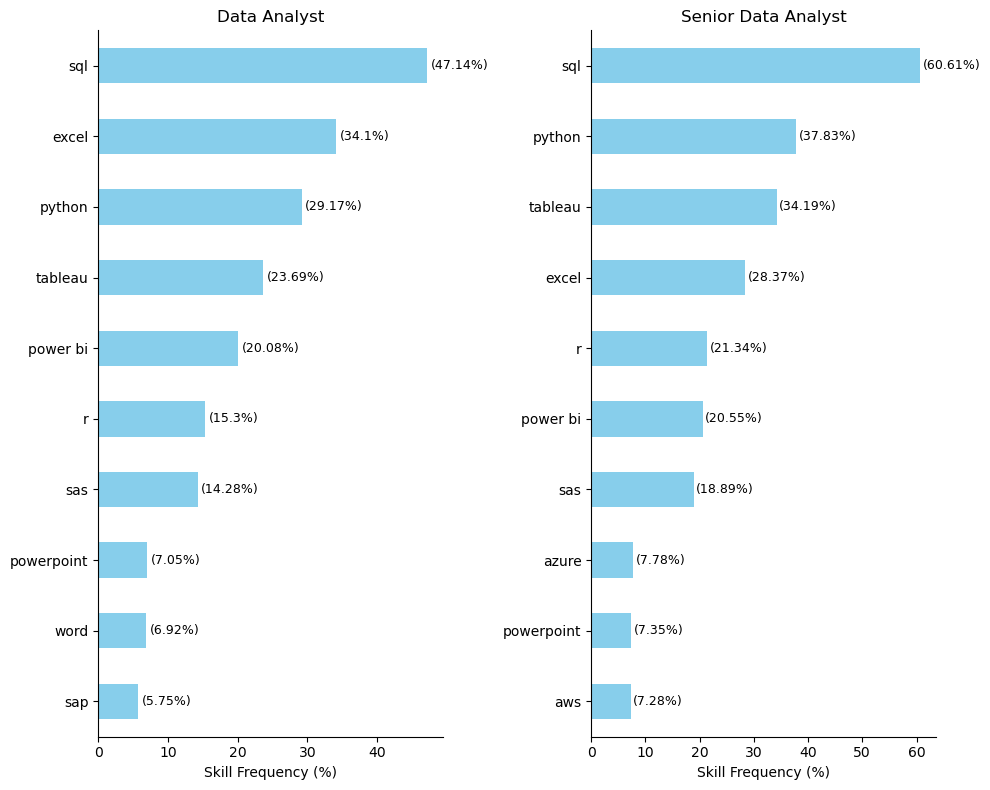

In [ ]:
data_exp=data.explode('job_skills')
jt_list = ['Data Analyst', 'Senior Data Analyst']
f, ax = mplp.subplots(1, 2, figsize=(10, 8))

for i, jt in enumerate(jt_list):
    # Top 10 skill counts
    a = (
        data_exp[data_exp.job_title_short == jt]
        .groupby('job_skills')
        .size()
        .sort_values(ascending=False)
        .head(10)
        .to_frame(name='skill_count')
    )
    
    # Total number of jobs for the title
    b = len(data[data.job_title_short == jt])
    
    # Calculate Percentage (Likelihood)
    c = (a['skill_count'] / b * 100).round(2).sort_values()

    c.plot(kind='barh', ax=ax[i], color='skyblue')
    ax[i].set_title(jt)
    ax[i].set_xlabel('Skill Frequency (%)')
    ax[i].set_ylabel('')

    # Add text
    for j, (skill, val) in enumerate(c.items()):
        ax[i].text(x=val + 0.5, y=j, s=f"({val}%)", va='center', fontsize=9)

sns.despine()
mplp.tight_layout()
mplp.show()


### Trend of Top Skills for Data Analysts in the US  

Monthly trends of the top 5 skills for `Data Analyst` roles in the United States are calculated and visualized with a line chart, showing the percentage of jobs requiring each skill.  


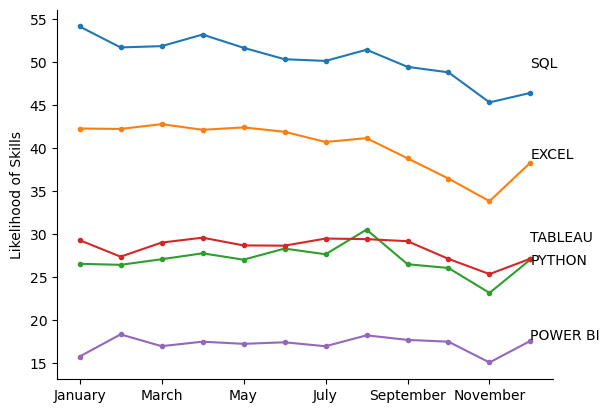

In [180]:
da=data_exp[(data_exp.job_title_short=='Data Analyst')]
das=da.job_skills.value_counts().head(5).index.to_list()
a=da[da.job_country=='United States'].groupby(['month','job_skills']).size().unstack().loc[:,das]
b=data[((data.job_country=='United States'))&(data.job_title_short=='Data Analyst')].groupby('month').size()
c=round(a.div(b,axis=0)*100,2)
month_ordered = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
c.index=pd.CategoricalIndex(c.index,categories=month_ordered,ordered=True)
c.sort_index().plot(kind='line',marker='o',markersize=3)
mplp.legend().set_visible(False)
mplp.ylabel('Likelihood of Skills')
sns.despine()
mplp.xlabel('')
mplp.legend().set_visible(False)
for i in range(5):
    mplp.text(x=11,y=c.iloc[11,i],s=c.columns[i].upper())

### Median Salary Comparison for Top Jobs Across Top 5 Countries  

Median yearly salaries of Data Analyst, Data Engineer, and Data Scientist roles are compared across the top 5 countries by job postings using a bar chart.  


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'India'),
  Text(2, 0, 'United Kingdom'),
  Text(3, 0, 'France'),
  Text(4, 0, 'Germany')])

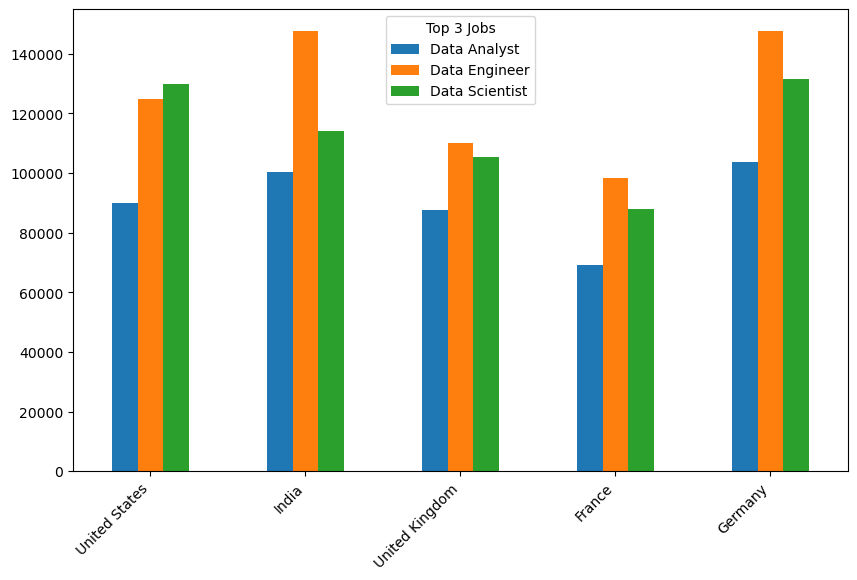

In [73]:

tfc=data.job_country.value_counts().head(5).index.to_list()
jts=['Data Analyst','Data Engineer','Data Scientist']
data[data.job_title_short.isin(jts)].groupby(['job_country','job_title_short'])['salary_year_avg'].median().loc[tfc].unstack().plot(kind='bar',figsize=(10,6),xlabel='')
mplp.legend(title='Top 3 Jobs')
mplp.xticks(rotation=45,ha='right')

### Monthly Job Posting Trends for Top Roles  

Line chart showing the number of monthly job postings for Data Analyst, Data Engineer, and Data Scientist roles.  


<Figure size 1200x600 with 0 Axes>

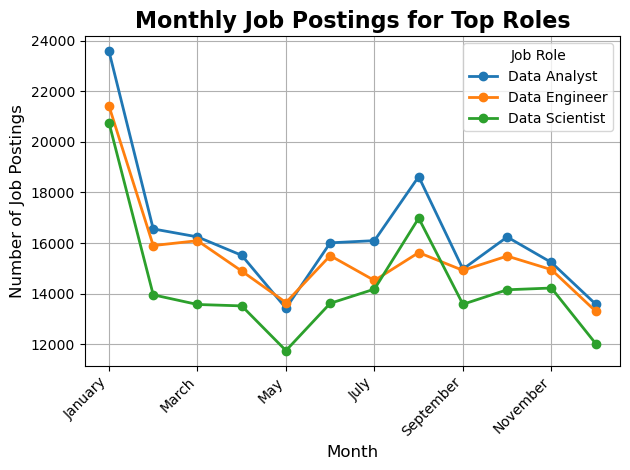

In [83]:
ab = data[data.job_title_short.isin(jts)].groupby(['month','job_title_short']).size().unstack().loc[:, jts]
ab.index = pd.CategoricalIndex(ab.index, categories=month_ordered, ordered=True)

mplp.figure(figsize=(12,6))
ab.sort_index().plot(
    kind='line', 
    marker='o', 
    linewidth=2, 
    markersize=6, 
    grid=True
)
mplp.title("Monthly Job Postings for Top Roles", fontsize=16, weight='bold')
mplp.xlabel("Month", fontsize=12)
mplp.ylabel("Number of Job Postings", fontsize=12)
mplp.xticks(rotation=45, ha='right')
mplp.legend(title='Job Role')
mplp.tight_layout()
mplp.show()


### Monthly Trend of Top Skills for Data Analysts  

Line chart showing the monthly frequency of the top 5 skills for Data Analyst roles.  


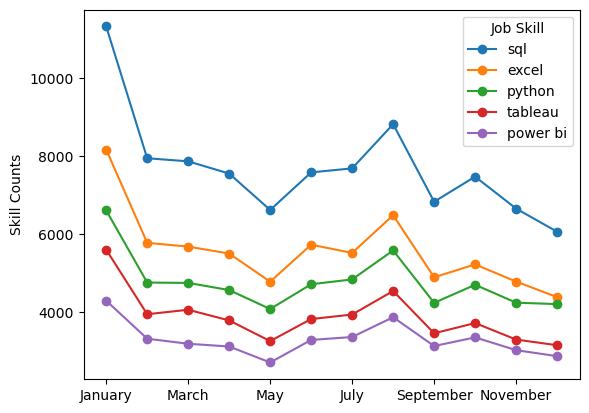

In [90]:
top_skills=da.job_skills.value_counts().head(5).index.to_list()
ab=da.groupby(['month','job_skills']).size().unstack().loc[:,top_skills]
ab.index=pd.CategoricalIndex(ab.index,categories=month_ordered,ordered=True)
ax=ab.sort_index().plot(kind='line',marker='o')
ax.set_xlabel('')
ax.set_ylabel('Skill Counts')
ax.legend(title='Job Skill')

### Key Skills Analysis for Leading Job Roles  

Subplots showing the top 5 most frequent skills for Data Analyst, Data Engineer, and Data Scientist roles.  


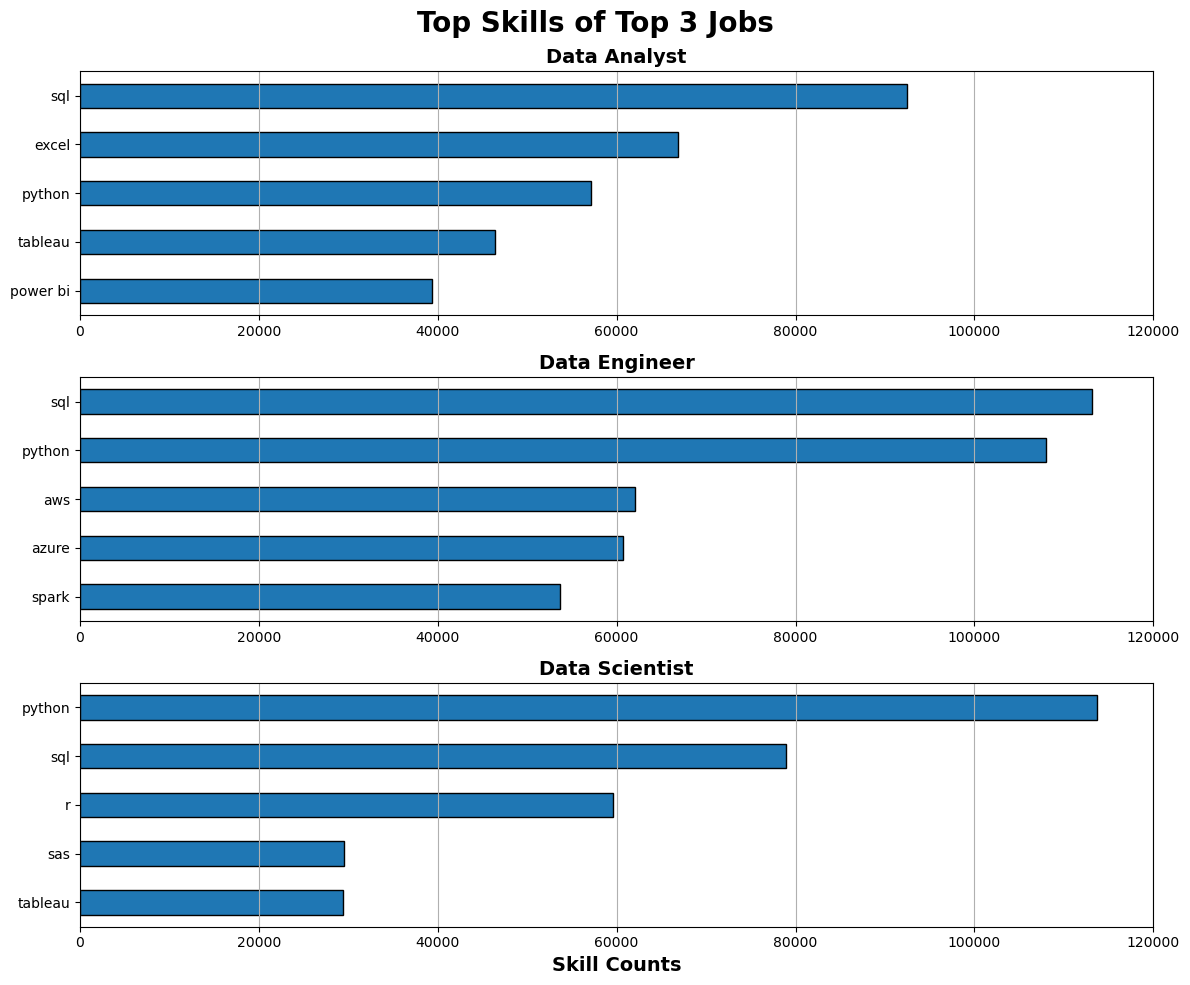

In [101]:
ttj = data.job_title_short.value_counts().head(3).index.to_list()
f, ax = mplp.subplots(3, 1, figsize=(12, 10))

for i, j in enumerate(ttj):
    top_skills = data_exp[data_exp.job_title_short == j].job_skills.value_counts().head(5).sort_values(ascending=True)
    top_skills.plot(
        kind='barh',
        ax=ax[i],
        edgecolor='black'
    )
    ax[i].set_title(j, fontsize=14, weight='bold')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].grid(axis='x')
    ax[i].set_xlim(0,120000)
    if i==2:
        ax[i].set_xlabel('Skill Counts',fontsize=14, weight='bold')


f.suptitle('Top Skills of Top 3 Jobs', fontsize=20, weight='bold')
f.tight_layout()
mplp.show()


### Job Benefits Distribution  

Pie charts showing the distribution of Work from Home, Degree Requirement, and Health Insurance across job postings.  


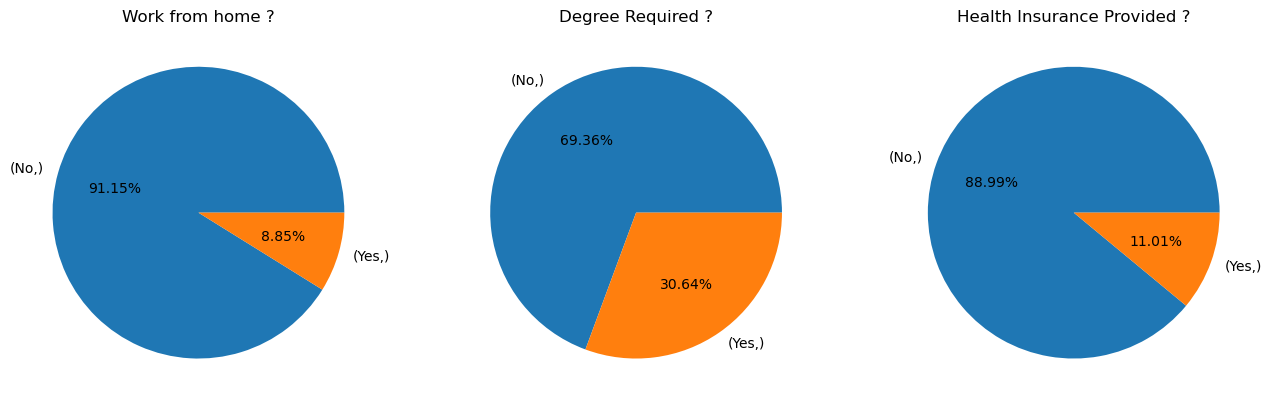

In [103]:
myd = {
    'job_work_from_home': 'Work from home ?',
    'job_no_degree_mention': 'Degree Required ?',
    'job_health_insurance': 'Health Insurance Provided ?'
}

f, ax = mplp.subplots(1, 3, figsize=(16, 12))

for i, (column, title) in enumerate(myd.items()):
    pd.DataFrame(np.where(data[column], 'Yes', 'No')).value_counts().plot(
        kind='pie', ax=ax[i], autopct='%1.2f%%'
    )
    ax[i].set_ylabel('')
    ax[i].set_title(title)


### Top Skills vs Median Salary for Data Analysts  

Scatter plot showing the relationship between job count and median salary for the top 10 skills in Data Analyst roles.  


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33068\425616500.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b.append(mplp.text(x=a.count_of_jobs[i],y=a.med_salary[i],s=sk))


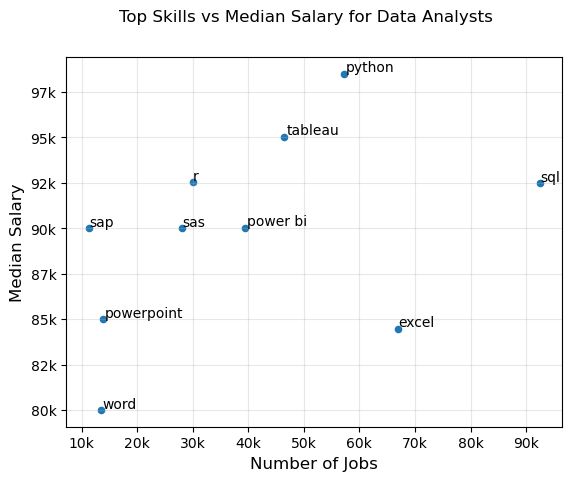

In [112]:
ttsda=da.job_skills.value_counts().head(10).index.to_list()
a=data_exp[data_exp.job_title_short=='Data Analyst'].groupby('job_skills').agg(med_salary=('salary_year_avg','median'),count_of_jobs=('job_skills','count')).loc[ttsda,:]
a.plot(kind='scatter',y='med_salary',x='count_of_jobs')
b=[]
for i,sk in enumerate(a.index):
    b.append(mplp.text(x=a.count_of_jobs[i],y=a.med_salary[i],s=sk))
from adjustText import adjust_text
adjust_text(b)

mplp.xlabel('Number of Jobs',fontsize=12)
mplp.grid(alpha=0.3)
mplp.ylabel('Median Salary',fontsize=12)
mplp.suptitle('Top Skills vs Median Salary for Data Analysts')

from matplotlib.ticker import FuncFormatter
mplp.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,_: f'{int(x/1000)}k'))
mplp.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y/1000)}k'))


### Salary Distribution by Job Title  

Boxplot showing yearly salary distributions across job titles, ordered by median salary.  


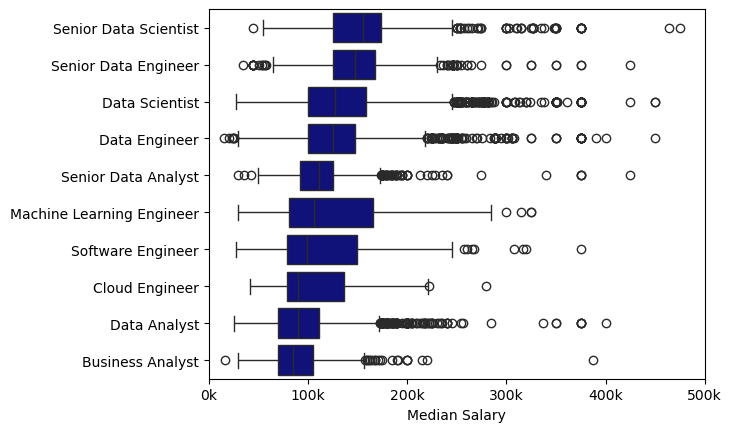

In [132]:
from matplotlib.ticker import FuncFormatter
job_or=data.groupby('job_title_short').agg(sal=('salary_year_avg','median')).sort_values(ascending=False,by ='sal').index.to_list()

ax = sns.boxplot(data=data, y='job_title_short', x='salary_year_avg', color='darkblue',order=job_or)

mplp.ylabel('')
mplp.xlabel('Median Salary')

mplp.xlim(0, 500000)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

mplp.show()


### Most Demanded and Highest Paying Skills for Data Analysts in the US  

Two horizontal bar charts comparing the top 10 most demanded skills and the top 10 highest paying skills for Data Analyst roles in the United States.  


<Axes: title={'center': 'Most Demanded Skills'}, xlabel='Median Salary'>

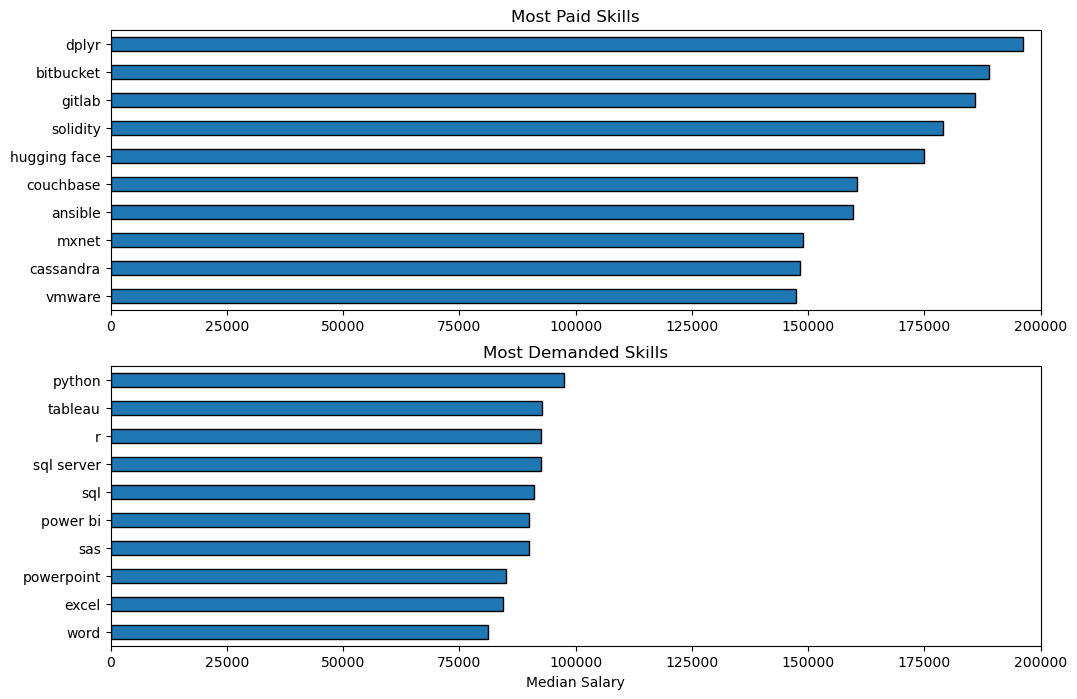

In [165]:
#most demanded and most paid
data_gr= data_exp[(data_exp.job_title_short=='Data Analyst')&(data.salary_year_avg.notna())&(data.job_country=='United States')].groupby('job_skills').agg(Median_Salary=('salary_year_avg','median'),Skill_Count=('job_skills','size'))
f,ax=mplp.subplots(2,1,figsize=(12,8))
data_gr['Median_Salary'].sort_values(ascending=False).head(10).sort_values().plot(kind='barh',xlabel='',ylabel='',title='Most Paid Skills',ax=ax[0],xlim=(0,200000),edgecolor='black')
data_gr.sort_values(by='Skill_Count',ascending=False).Median_Salary.to_frame().head(10).sort_values(by='Median_Salary').plot(kind='barh',xlabel='Median Salary',ylabel='',title='Most Demanded Skills',ax=ax[1],legend=False,xlim=(0,200000),edgecolor='black')


### Top 5 Job Skills by Role (Percentage-Based)  

Bar charts showing the top 5 most frequent skills for Data Analyst, Data Engineer, and Data Scientist roles, expressed as percentages of total postings.  

The percentages are calculated as:  
  **(Skill count for that role) / (Total postings for that role) × 100**


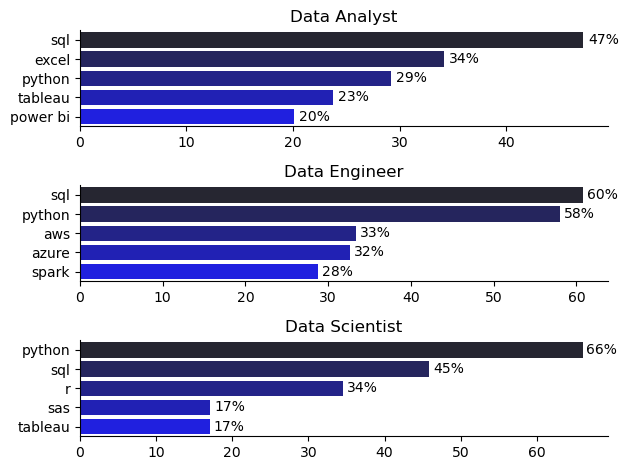

In [175]:
ttj=['Data Analyst', 'Data Engineer', 'Data Scientist']
f,ax=mplp.subplots(3,1)
for k,jt in enumerate(ttj):
    a=data_exp[data_exp.job_title_short==jt].job_skills.value_counts().head(5)/len(data[data.job_title_short==jt])
    a=round(a*100,2).sort_values()
    sns.barplot(data=a.sort_values(ascending=False).reset_index(),x='count',y='job_skills',ax=ax[k],hue='job_skills',palette='dark:b')
    sns.despine(ax=ax[k])
    ax[k].set_xlabel('')
    ax[k].set_ylabel('')
    ax[k].set_title(jt)
    al=a.index.to_list()
    for i,sk in enumerate(a.index):
        ax[k].text(x=a.sort_values(ascending=False).values[i]+0.5,y=i,s=f'{int(a.sort_values(ascending=False).values[i])}%',va='center')

f.tight_layout()